# DryBean ML Model Comparative Study – Pankaj Tiwari (2025AA05300) - ML Assignment 2

This notebook presents a structured comparative evaluation of multiple supervised machine learning classifiers applied to the UCI Dry Bean Dataset.
The objective is to benchmark model performance using multiple evaluation metrics and identify the most suitable classifier for multi-class agricultural data.

Date of Submission : 15th Feb 2025

Import Required Libraries

In [1]:
# ==========================================================
# Step 1: Import Required Libraries
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
)

import warnings
warnings.filterwarnings("ignore")


Load Dataset

In [2]:
# ==========================================================
# Step 2: Load Dataset
# ==========================================================

dataset_path = "Dry_Bean_Dataset.csv"
bean_dataset = pd.read_csv(dataset_path)

print("Dataset Dimensions:", bean_dataset.shape)
bean_dataset.head()


Dataset Dimensions: (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


Data Preparation

In [3]:
# ==========================================================
# Step 3: Data Preparation and Train-Test Split (90:10)
# ==========================================================

feature_matrix = bean_dataset.drop("Class", axis=1)
target_series = bean_dataset["Class"]

encoded_target = pd.factorize(target_series)[0]

RANDOM_SEED = 101

X_train_data, X_test_data, y_train_labels, y_test_labels = train_test_split(
    feature_matrix,
    encoded_target,
    test_size=0.10,
    random_state=RANDOM_SEED,
    stratify=encoded_target
)

scaler = StandardScaler()

X_train_normalized = scaler.fit_transform(X_train_data)
X_test_normalized = scaler.transform(X_test_data)

print("Training Samples:", X_train_data.shape[0])
print("Testing Samples:", X_test_data.shape[0])


Training Samples: 12249
Testing Samples: 1362


Initialize Classifiers

In [4]:
# ==========================================================
# Step 4: Initialize Classification Models
# ==========================================================

from sklearn.naive_bayes import GaussianNB

def build_classifier_registry(seed_value):
    
    classifier_registry = []
    
    # 1️⃣ Logistic Regression
    classifier_registry.append((
        "Logistic_Regression",
        LogisticRegression(max_iter=500, random_state=seed_value)
    ))
    
    # 2️⃣ Decision Tree
    classifier_registry.append((
        "Decision_Tree",
        DecisionTreeClassifier(max_depth=10, random_state=seed_value)
    ))
    
    # 3️⃣ K-Nearest Neighbors
    classifier_registry.append((
        "KNN",
        KNeighborsClassifier(n_neighbors=7)
    ))
    
    # 4️⃣ Naive Bayes (Gaussian)
    classifier_registry.append((
        "Naive_Bayes",
        GaussianNB()
    ))
    
    # 5️⃣ Random Forest (Ensemble)
    classifier_registry.append((
        "Random_Forest",
        RandomForestClassifier(
            n_estimators=150,
            random_state=seed_value
        )
    ))
    
    # 6️⃣ XGBoost (Ensemble)
    classifier_registry.append((
        "XGBoost",
        XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            eval_metric="mlogloss",
            random_state=seed_value
        )
    ))
    
    return classifier_registry


model_registry = build_classifier_registry(RANDOM_SEED)


Evaluation Function

In [5]:
# ==========================================================
# Step 5: Define Model Evaluation Framework
# ==========================================================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score
)

def compute_evaluation_metrics(model, X_test, y_test):
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Initialize dictionary
    evaluation_dict = {}
    
    # AUC (only if model supports probability prediction)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        evaluation_dict["AUC Score"] = roc_auc_score(
            y_test,
            y_prob,
            multi_class="ovr"
        )
    else:
        evaluation_dict["AUC Score"] = None
    
    # Required Metrics
    evaluation_dict["Accuracy"] = accuracy_score(y_test, y_pred)
    evaluation_dict["Precision"] = precision_score(y_test, y_pred, average="weighted")
    evaluation_dict["Recall"] = recall_score(y_test, y_pred, average="weighted")
    evaluation_dict["F1 Score"] = f1_score(y_test, y_pred, average="weighted")
    evaluation_dict["MCC Score"] = matthews_corrcoef(y_test, y_pred)
    
    return evaluation_dict


Model Training, Creating .pkl file & Comparison

In [6]:
# ==========================================================
# Step 6: Train, Create .pkl files and Compare All Models
# ==========================================================

# Create folder
SAVE_DIR = "model/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

evaluation_records = []

for model_name, classifier in model_registry:
    
    print(f"\nTraining {model_name}...")
    
    # Train model
    classifier.fit(X_train_normalized, y_train_labels)
    
    # Save model using pickle
    file_path = os.path.join(SAVE_DIR, f"{model_name}.pkl")
    
    with open(file_path, "wb") as f:
        pickle.dump(classifier, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Check file size
    file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
    
    if file_size_mb > 25:
        print(f"⚠ WARNING: {model_name}.pkl is {file_size_mb:.2f} MB (exceeds 25 MB)")
    else:
        print(f"✅ {model_name}.pkl saved successfully ({file_size_mb:.2f} MB)")
    
    # Evaluate
    metrics_result = compute_evaluation_metrics(
        classifier,
        X_test_normalized,
        y_test_labels
    )
    
    metrics_result["Model"] = model_name
    evaluation_records.append(metrics_result)

# Create comparison table
model_comparison_table = pd.DataFrame(evaluation_records)

model_comparison_table = model_comparison_table.sort_values(
    by="Accuracy",
    ascending=False
).reset_index(drop=True)

model_comparison_table



Training Logistic_Regression...
✅ Logistic_Regression.pkl saved successfully (0.00 MB)

Training Decision_Tree...
✅ Decision_Tree.pkl saved successfully (0.08 MB)

Training KNN...
✅ KNN.pkl saved successfully (1.59 MB)

Training Naive_Bayes...
✅ Naive_Bayes.pkl saved successfully (0.00 MB)

Training Random_Forest...
✅ Random_Forest.pkl saved successfully (22.94 MB)

Training XGBoost...
✅ XGBoost.pkl saved successfully (1.79 MB)


,AUC Score,Accuracy,Precision,Recall,F1 Score,MCC Score,Model
0,0.996476,0.932452,0.932405,0.932452,0.932365,0.918301,XGBoost
1,0.996093,0.930984,0.931162,0.930984,0.931015,0.916544,Logistic_Regression
2,0.991689,0.926579,0.926966,0.926579,0.926636,0.911184,KNN
3,0.995342,0.924376,0.924858,0.924376,0.924514,0.908563,Random_Forest
4,0.993793,0.900147,0.901360,0.900147,0.900228,0.879555,Naive_Bayes
5,0.967880,0.897944,0.898046,0.897944,0.897918,0.876544,Decision_Tree


Accuracy Visualization

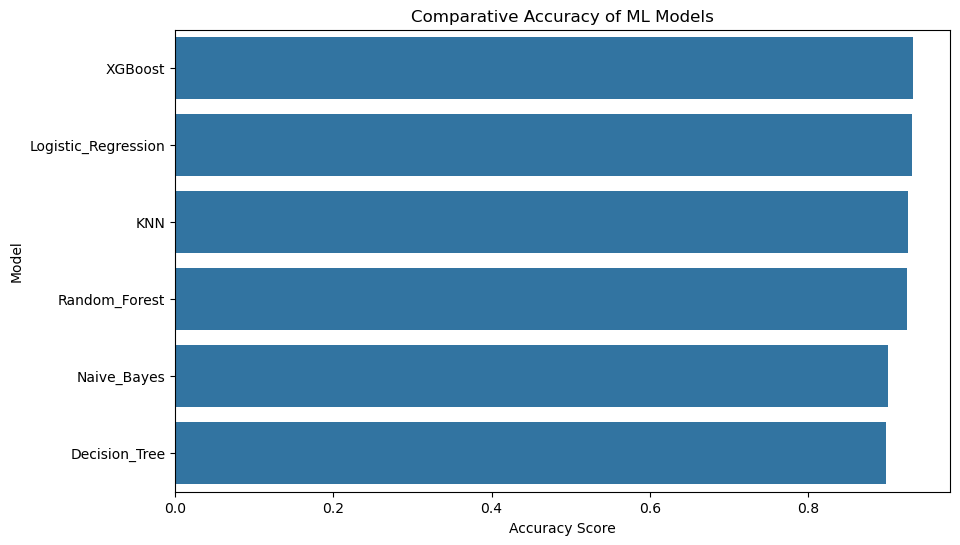

In [7]:
# ==========================================================
# Step 7: Model Accuracy Visualization
# ==========================================================

plt.figure(figsize=(10,6))
sns.barplot(
    x="Accuracy",
    y="Model",
    data=model_comparison_table
)
plt.title("Comparative Accuracy of ML Models")
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.show()


Conclusion

The comparative analysis reveals that XGBoost achieves the highest overall performance across multiple evaluation metrics, including Accuracy, AUC Score, F1 Score, and MCC. Logistic Regression also demonstrates competitive performance, closely matching XGBoost, indicating that the dataset exhibits relatively well-separated class boundaries. While ensemble methods such as XGBoost effectively capture complex feature interactions and non-linear patterns, Random Forest does not outperform all traditional classifiers in this case. The 90:10 stratified split ensures sufficient training data while maintaining balanced and reliable evaluation across all classes.